## Imports

In [1]:
import anndata as ad
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import orbax
import scanpy as sc
from flatten_dict import flatten
from flax.linen.activation import gelu
from matplotlib import patches
from omegaconf import OmegaConf
from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn

import spacetime
from spacetime import potentials, steps

In [2]:
# Check that we use the GPU
jax.devices()

[CpuDevice(id=0)]

## Load config file

In [3]:
# Define the path for the config and weights
path = "../space-time/tmp/artista_june_linear_6fallh1m/"

In [4]:
cfg = flatten(OmegaConf.load(path + "config.yaml"), reducer="dot")

In [5]:
cfg

{'checkpoint_path': '/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/space-time/tmp/artista_june_linear',
 'n_pcs': 20,
 'model.epsilon': 0.01,
 'model.debias': True,
 'model.teacher_forcing': True,
 'model.n_steps': 1,
 'model.quadratic': False,
 'model.quadratic_weight': 0.0,
 'model.seed': 20181,
 'potential.features': [128, 128],
 'step.type': 'explicit',
 'step.implicit_diff': True,
 'step.maxiter': 100,
 'optimizer.train_val_split': 0.75,
 'optimizer.learning_rate': 0.01,
 'optimizer.checkpoint_interval': 1,
 'optimizer.max_iter': 15000,
 'optimizer.batch_size': 1000,
 'optimizer.min_delta': 0.0,
 'optimizer.patience': 150,
 'wandb.mode': 'offline',
 'organism.dataset_path': '/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/artista_processed.h5ad',
 'organism.omics_key': 'X_pca_harmony',
 'organism.space_key': 'spatial',
 'organism.weight_key': None,
 'organism.annotation_key': 'Annotation',
 'organism.time_key': 'time',
 'organism.train_batches': ['Injury_2DPI_

## Load data

In [6]:
# Load the anndata object
adata = ad.read_h5ad("../data/artista/artista_processed.h5ad")

In [7]:
# Get the indices for the training, early test, and late test batches.
idx_train = np.isin(adata.obs["Batch"], cfg["organism.train_batches"])
idx_early_test = np.isin(adata.obs["Batch"], cfg["organism.early_test_batches"])
idx_late_test = np.isin(adata.obs["Batch"], cfg["organism.late_test_batches"])

## Preprocess data

In [8]:
# Normalize the omics information
adata.obsm[cfg["organism.omics_key"]] = adata.obsm[cfg["organism.omics_key"]][
    :, : cfg["n_pcs"]
]
adata.obsm[cfg["organism.omics_key"]] /= adata.obsm[cfg["organism.omics_key"]].max()

In [9]:
# Center and scale each timepoint in space.
adata.obsm[cfg["organism.space_key"]] = adata.obsm[cfg["organism.space_key"]].astype(
    float
)
for b in np.unique(adata.obs["Batch"]):
    idx = adata.obs["Batch"] == b

    mu = np.mean(adata.obsm[cfg["organism.space_key"]][idx, :], axis=0)
    adata.obsm[cfg["organism.space_key"]][idx, :] -= mu

    sigma = np.std(adata.obsm[cfg["organism.space_key"]][idx, :], axis=0)
    adata.obsm[cfg["organism.space_key"]][idx, :] /= sigma

## Initialize the model

In [10]:
# Initialize the model.
my_model = spacetime.SpaceTime(
    potential=potentials.MLPPotential(cfg["potential.features"], activation=gelu),
    proximal_step=steps.ExplicitStep(),
    teacher_forcing=cfg["model.teacher_forcing"],
    quadratic=cfg["model.quadratic"],
    epsilon=cfg["model.epsilon"],
    quadratic_weight=cfg["model.quadratic_weight"],
    debias=cfg["model.debias"],
)

In [11]:
# Retrieve the latest weights
options = orbax.checkpoint.CheckpointManagerOptions(
    save_interval_steps=cfg["optimizer.checkpoint_interval"],
    max_to_keep=1,
    best_fn=lambda x: x["loss"],
    best_mode="min",
)
checkpoint_manager = orbax.checkpoint.CheckpointManager(
    path + "checkpoints",
    orbax.checkpoint.PyTreeCheckpointer(),
    options=options,
)
best_epoch = checkpoint_manager.best_step()
my_model.params = checkpoint_manager.restore(best_epoch)

## Transform data

In [12]:
def pred(
    adata: ad.AnnData,
    idx_batches: np.ndarray,
    time_obs: str,
    my_model: spacetime.SpaceTime,
    omics_key: str,
):
    """Transform the data given a subet of batches."""

    # List timepoints and time differences between them.
    timepoints = np.sort(adata[idx_batches].obs[time_obs].unique())
    t_diff = np.diff(timepoints).astype(float)

    # Iterate over timepoints and transform the data.
    for i, t in enumerate(timepoints[:-1]):
        idx = (adata.obs[time_obs] == t) & idx_batches
        adata.obsm["pred"][idx] = my_model.transform(
            adata[idx], omics_key=omics_key, batch_size=500, tau=t_diff[i]
        )

In [13]:
# Initialize the prediction.
adata.obsm["pred"] = adata.obsm[cfg["organism.omics_key"]].copy()
adata.obs[cfg["organism.time_key"]] = adata.obs[cfg["organism.time_key"]].astype(float)

# Transform the data on training batches, early and late test batches.
pred(adata, idx_train, cfg["organism.time_key"], my_model, cfg["organism.omics_key"])
pred(
    adata, idx_early_test, cfg["organism.time_key"], my_model, cfg["organism.omics_key"]
)
pred(
    adata, idx_late_test, cfg["organism.time_key"], my_model, cfg["organism.omics_key"]
)

## Display spatial coordinates

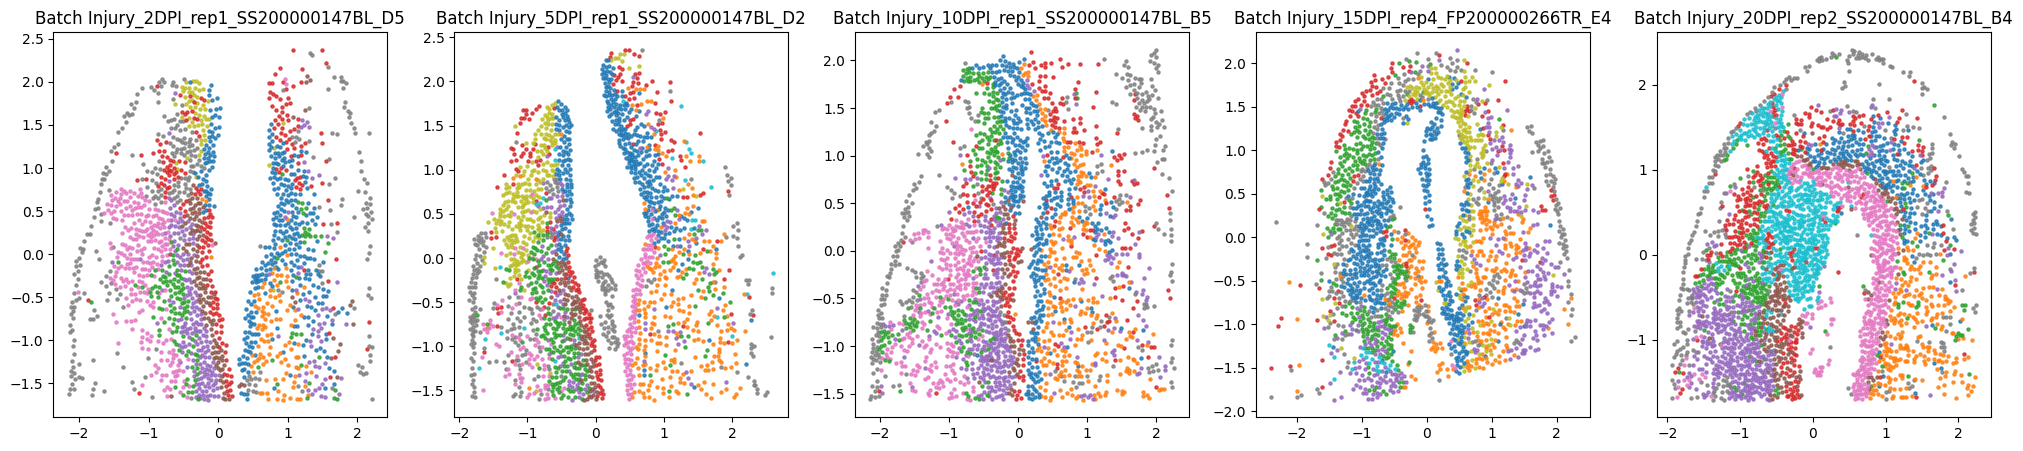

In [14]:
# Plot the space for each training batch, color by annotation
n_slices = len(cfg["organism.train_batches"])
fig, axes = plt.subplots(1, n_slices, figsize=(5 * n_slices, 5))
for i, batch in enumerate(cfg["organism.train_batches"]):
    idx = adata.obs["Batch"] == batch
    for j in np.unique(adata.obs[cfg["organism.annotation_key"]]):
        idx_ = idx & (adata.obs[cfg["organism.annotation_key"]] == j)
        axes[i].scatter(
            adata.obsm[cfg["organism.space_key"]][idx_, 0],
            adata.obsm[cfg["organism.space_key"]][idx_, 1],
            label=j,
            alpha=0.8,
            s=5,
        )
    axes[i].set_title(f"Batch {batch}")
plt.show()

## Display omics coordinates and prediction

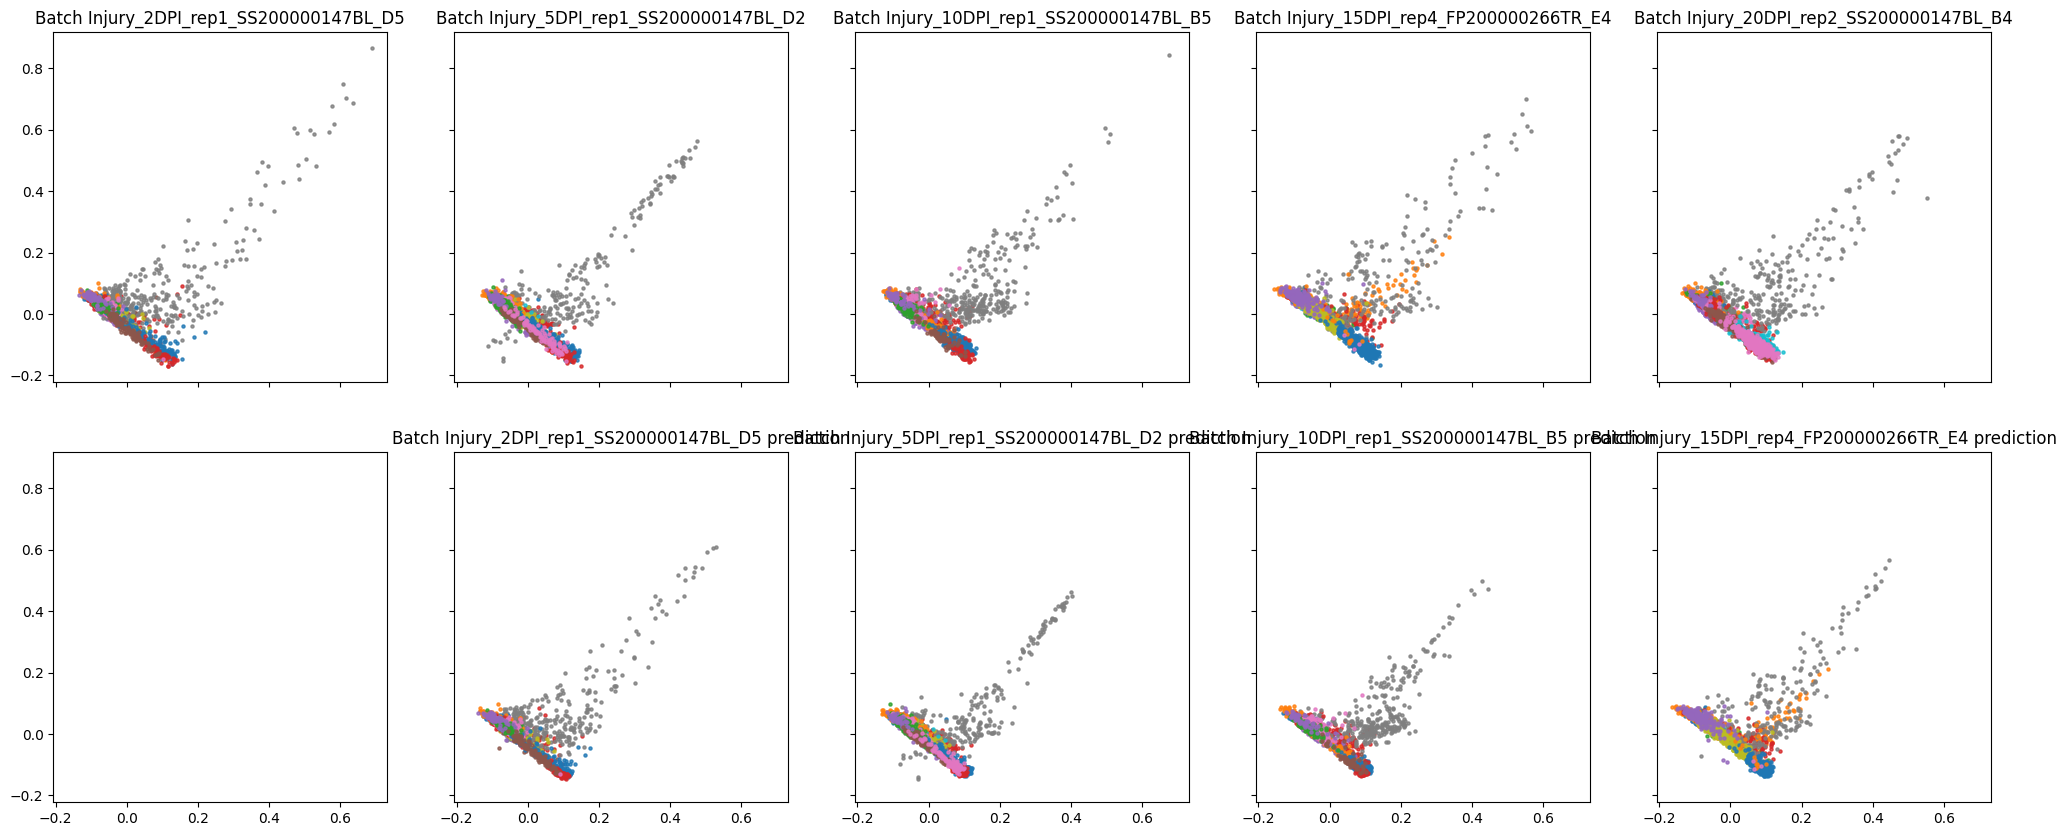

In [15]:
# Plot the space for each training batch, color by annotation
n_slices = len(cfg["organism.train_batches"])
fig, axes = plt.subplots(
    2, n_slices, figsize=(5 * n_slices, 10), sharex=True, sharey=True
)

for i, batch in enumerate(cfg["organism.train_batches"]):
    idx = adata.obs["Batch"] == batch
    for j in np.unique(adata.obs[cfg["organism.annotation_key"]]):
        idx_ = idx & (adata.obs[cfg["organism.annotation_key"]] == j)
        axes[0, i].scatter(
            adata.obsm[cfg["organism.omics_key"]][idx_, 0],
            adata.obsm[cfg["organism.omics_key"]][idx_, 1],
            label=j,
            alpha=0.8,
            s=5,
        )
    axes[0, i].set_title(f"Batch {batch}")

for i, batch in enumerate(cfg["organism.train_batches"][:-1]):
    idx = adata.obs["Batch"] == batch
    for j in np.unique(adata.obs[cfg["organism.annotation_key"]]):
        idx_ = idx & (adata.obs[cfg["organism.annotation_key"]] == j)
        axes[1, i + 1].scatter(
            adata.obsm["pred"][idx_, 0],
            adata.obsm["pred"][idx_, 1],
            label=j,
            alpha=0.8,
            s=5,
        )
    axes[1, i + 1].set_title(f"Batch {batch} prediction")
plt.show()

## Compute a Sinkhorn coupling

In [16]:
# Define the batches to compare
batch_left, batch_right = (
    cfg["organism.train_batches"][-2],
    cfg["organism.train_batches"][-1],
)
idx_left, idx_right = (
    adata.obs["Batch"] == batch_left,
    adata.obs["Batch"] == batch_right,
)

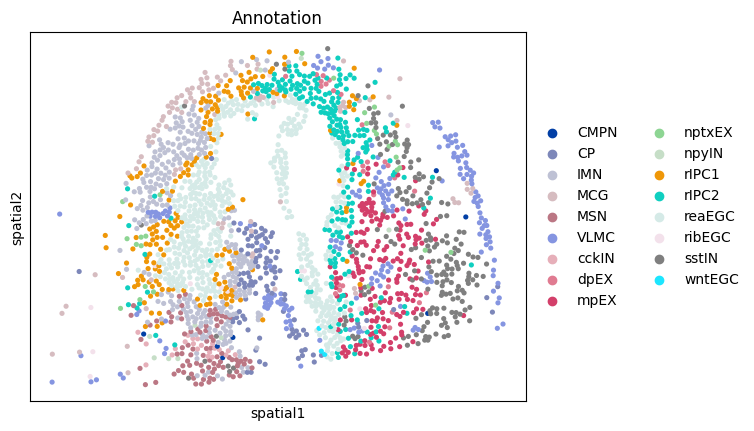

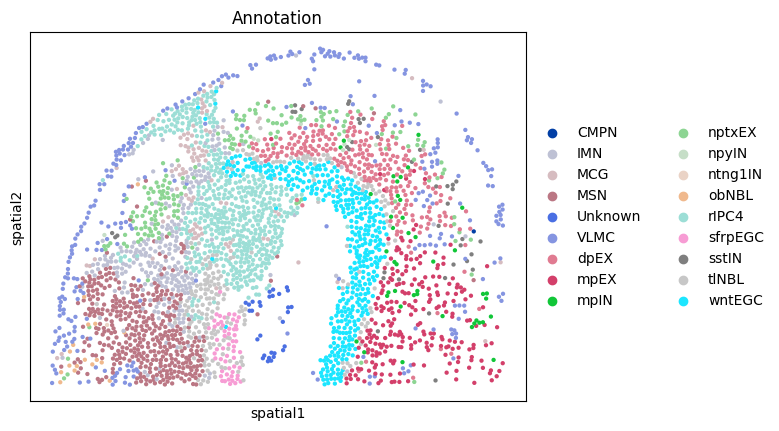

In [17]:
sc.pl.embedding(adata[idx_left], basis=cfg["organism.space_key"], color="Annotation")
sc.pl.embedding(adata[idx_right], basis=cfg["organism.space_key"], color="Annotation")

In [18]:
# Define the geometries
geom_xx = PointCloud(adata.obsm[cfg["organism.space_key"]][idx_left, :])
geom_yy = PointCloud(adata.obsm[cfg["organism.space_key"]][idx_right, :])
geom_xy = PointCloud(
    adata.obsm["pred"][idx_left, :],
    adata.obsm[cfg["organism.omics_key"]][idx_right, :],
    epsilon=cfg["model.epsilon"],
)

In [19]:
# Define the problem
problem = LinearProblem(geom_xy)

In [20]:
# Define the solver
solver = Sinkhorn()

In [21]:
# Solve the problem
out_sink = solver(problem)

In [22]:
import matplotlib

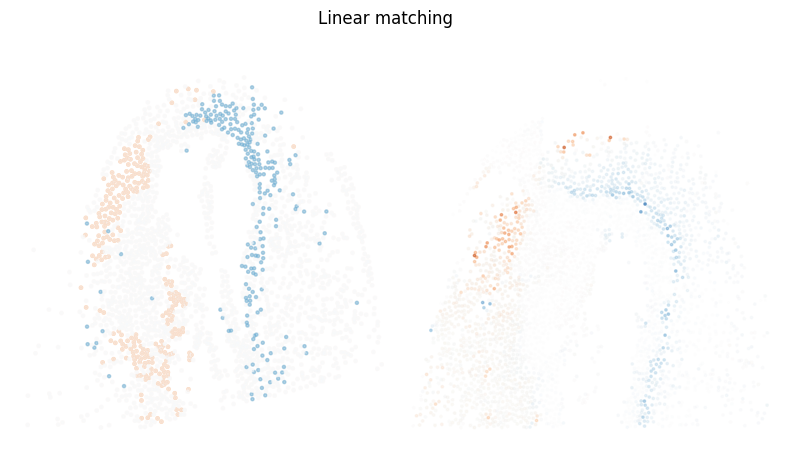

In [23]:
# Materialize the transport plan.
plan = out_sink.matrix

# Init the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Define the two annotations to plot
annot_1, annot_2 = "IMN", "rIPC2"
annot_vector_1 = adata[idx_left].obs["Annotation"] == annot_1
annot_vector_2 = adata[idx_left].obs["Annotation"] == annot_2

# Plot the left batch, colored by annotation
xx = adata.obsm[cfg["organism.space_key"]][idx_left, 0]
yy = adata.obsm[cfg["organism.space_key"]][idx_left, 1]
kwargs = {"vmax": 2, "alpha": 0.5, "s": 5}
axes[0].scatter(xx, yy, c=annot_vector_1, cmap="Oranges", **kwargs)
axes[0].scatter(xx, yy, c=annot_vector_2, cmap="Blues", **kwargs)

# Plot the right batch, colored by the transport plan
xx = adata.obsm[cfg["organism.space_key"]][idx_right, 0]
yy = adata.obsm[cfg["organism.space_key"]][idx_right, 1]

oranges = plt.cm.Oranges(np.linspace(0, 0.8, 256))
oranges[:, 3] = 0.5 * np.linspace(0, 1, 256) ** 2
cmap = matplotlib.colors.ListedColormap(oranges)
push = out_sink.apply(jnp.array(annot_vector_1))
kwargs = {"s": 3, "vmin": push.min(), "vmax": push.max()}
axes[1].scatter(xx, yy, c=push, cmap=cmap, **kwargs)

blues = plt.cm.Blues(np.linspace(0, 0.8, 256))
blues[:, 3] = 0.5 * np.linspace(0, 1, 256) ** 2
cmap = matplotlib.colors.ListedColormap(blues)
push = out_sink.apply(jnp.array(annot_vector_2))
kwargs = {"s": 3, "vmin": push.min(), "vmax": push.max()}
axes[1].scatter(xx, yy, c=push, cmap=cmap, **kwargs)

# Move axes[1] a bit to the left
plt.subplots_adjust(wspace=-0.01)

# Despine both axes
axes[0].spines[["top", "right", "left", "bottom"]].set_visible(False)
axes[1].spines[["top", "right", "left", "bottom"]].set_visible(False)

# Remove backgrounds
axes[0].set_facecolor("none")
axes[1].set_facecolor("none")

# Remove ticks
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[0].set_title("")
axes[1].set_title("")
plt.suptitle("Linear matching")
plt.savefig("figs/artista_linear_matching.png", dpi=500)
plt.show()

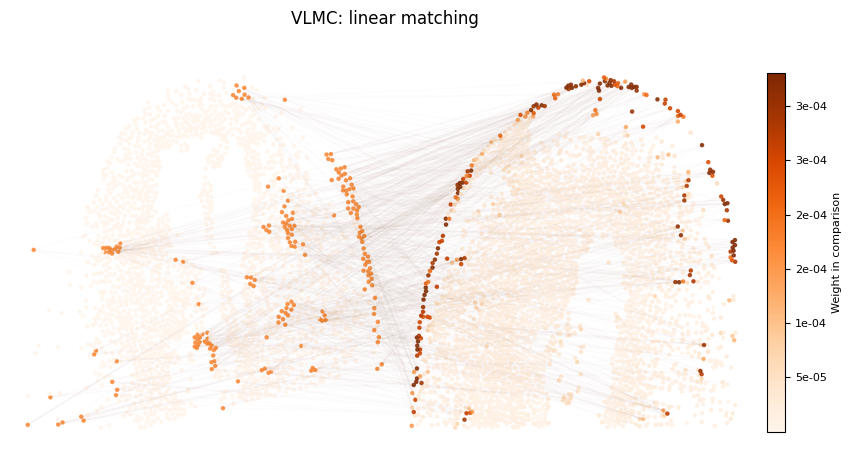

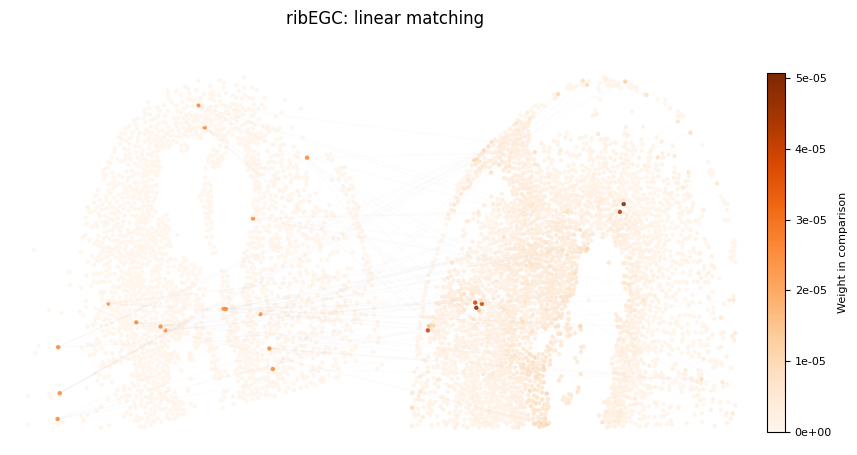

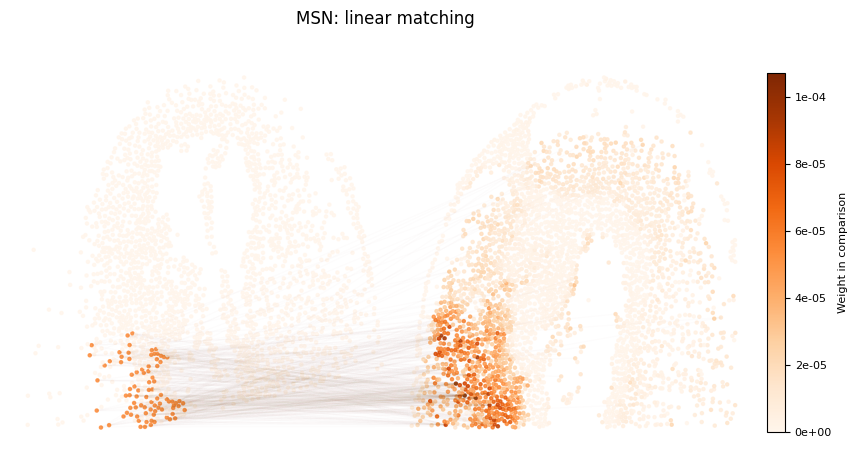

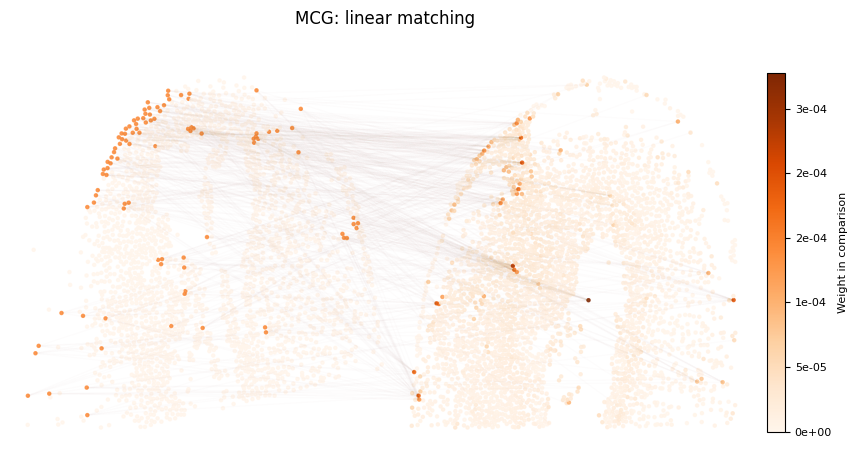

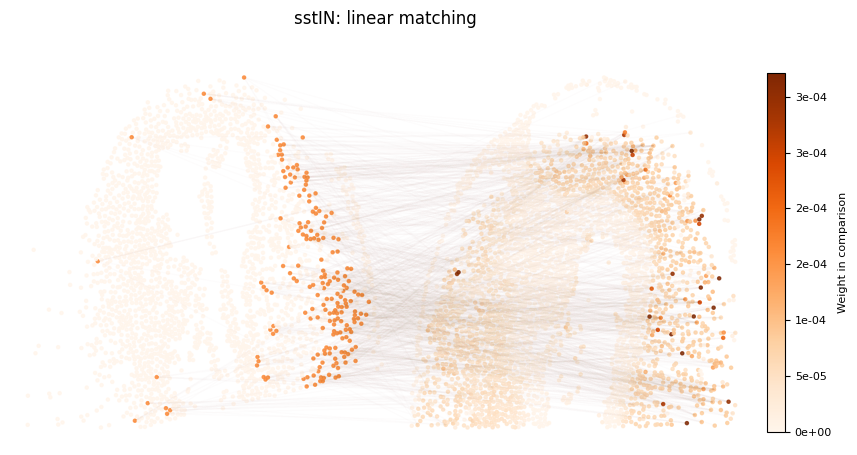

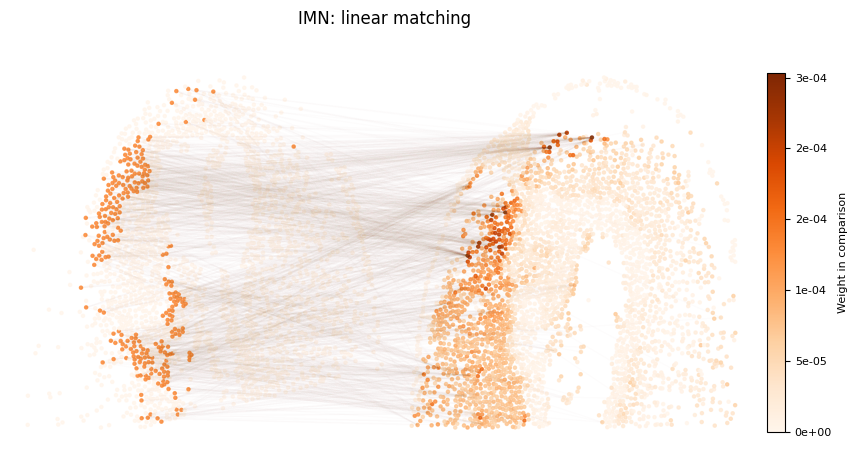

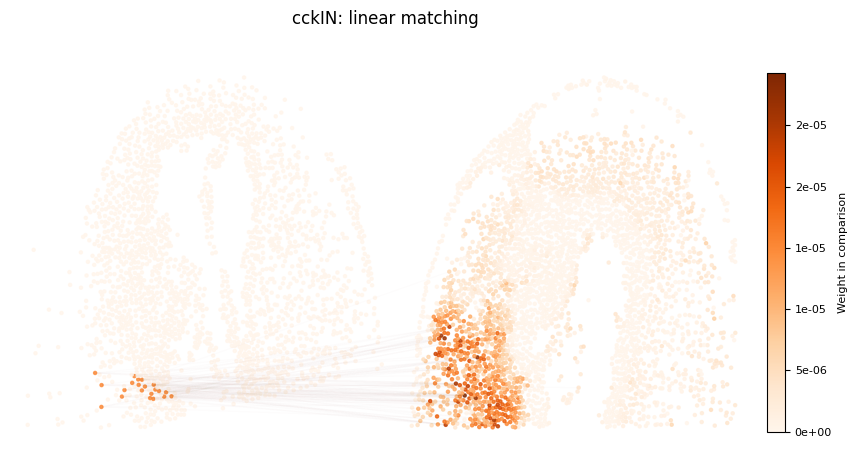

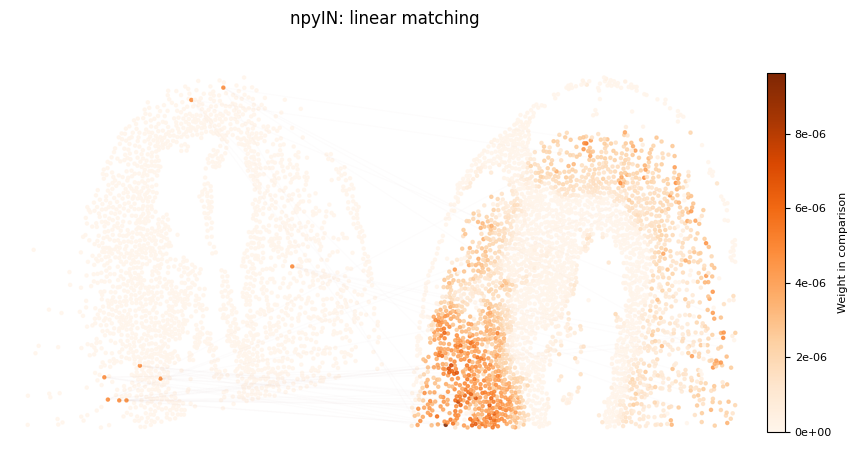

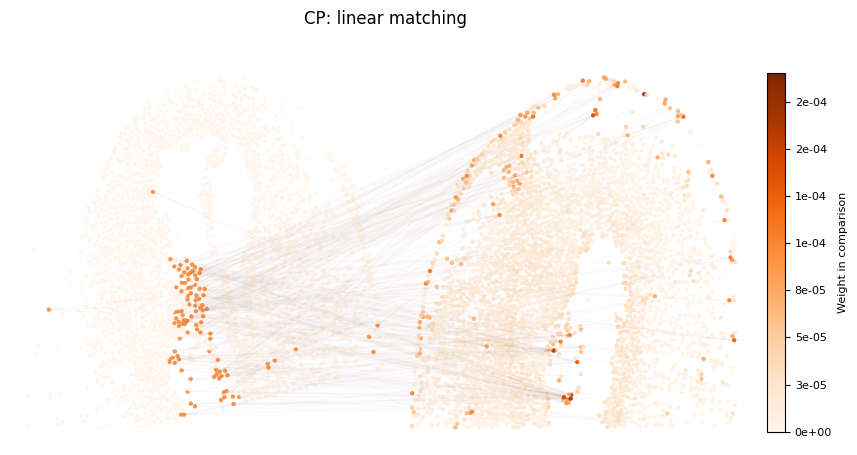

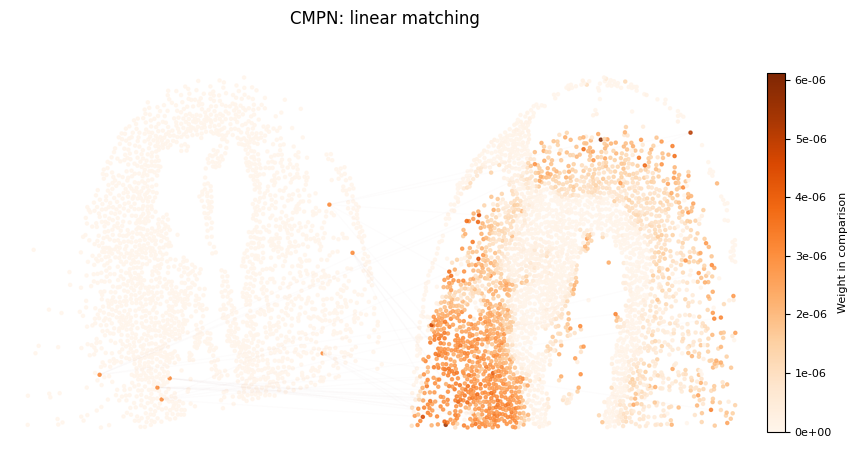

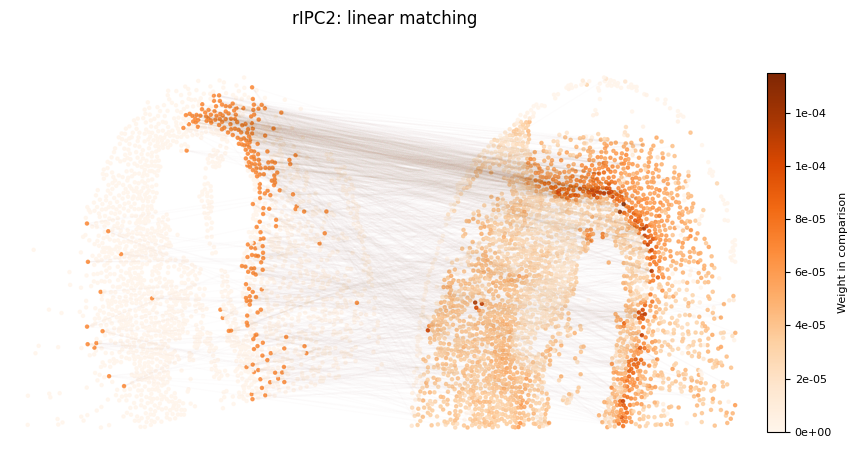

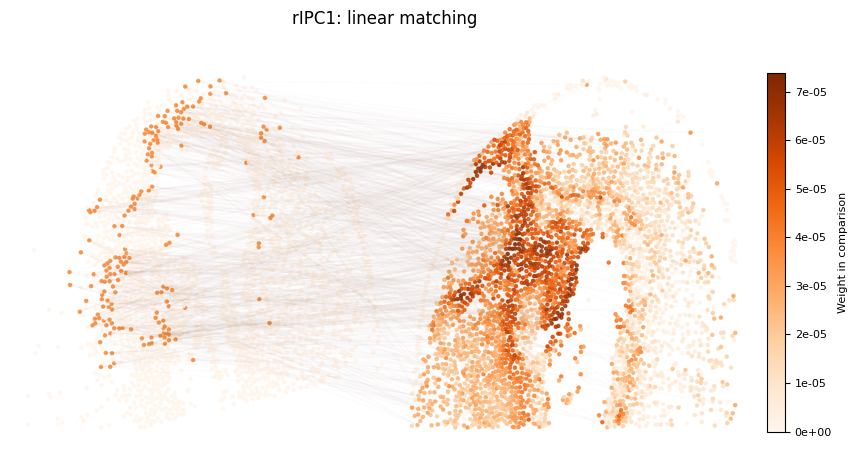

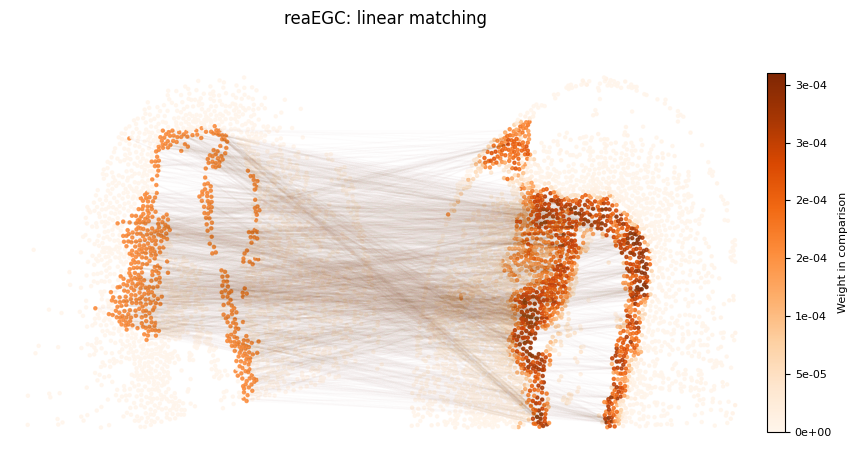

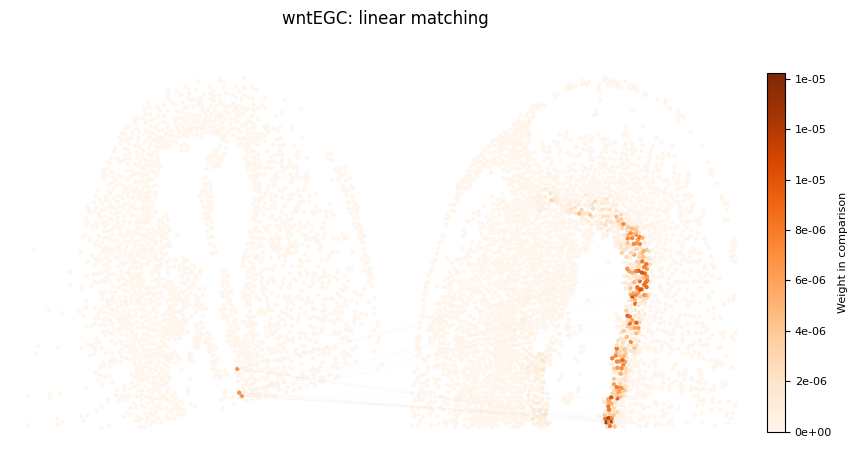

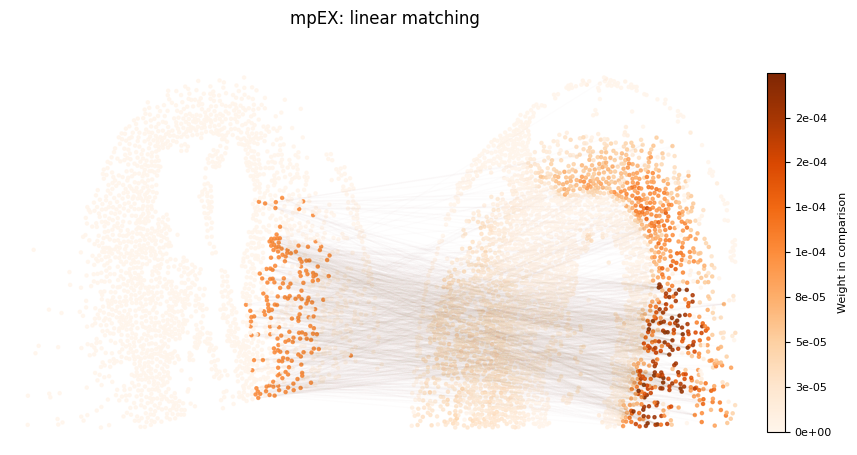

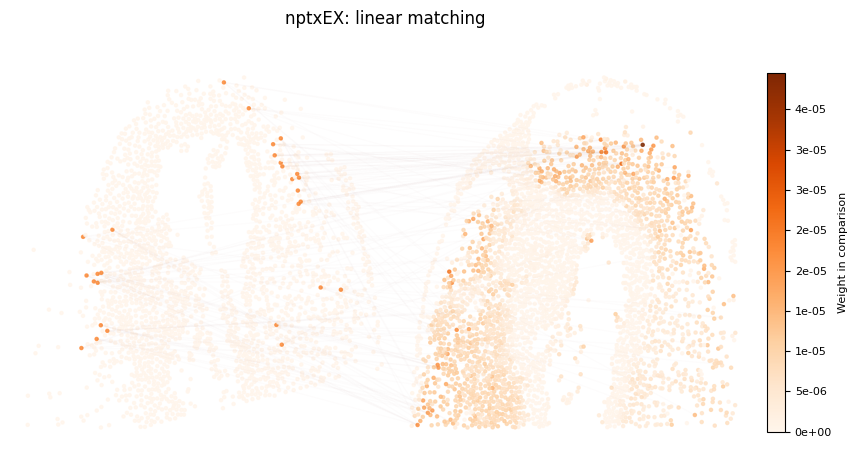

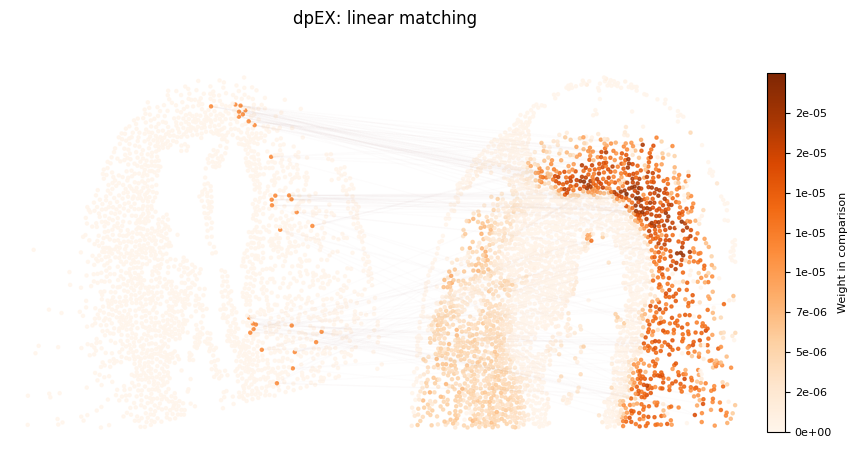

In [24]:
# Plot the left and right batches, colored by annotation
plan = out_sink.matrix
for annot in adata[idx_left].obs["Annotation"].unique():
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    annot_vector = adata[idx_left].obs["Annotation"] == annot
    axes[0].scatter(
        adata.obsm[cfg["organism.space_key"]][idx_left, 0],
        adata.obsm[cfg["organism.space_key"]][idx_left, 1],
        c=annot_vector,
        cmap="Oranges",
        vmax=2,
        alpha=0.8,
        s=5,
    )

    push = out_sink.apply(jnp.array(annot_vector))
    axes[1].scatter(
        adata.obsm[cfg["organism.space_key"]][idx_right, 0],
        adata.obsm[cfg["organism.space_key"]][idx_right, 1],
        c=push,
        vmax=push.max(),
        vmin=push.min(),
        cmap="Oranges",
        alpha=0.8,
        s=5,
    )

    # Move axes[1] a bit to the left
    plt.subplots_adjust(wspace=-0.01)

    # Colorbar on the sexond axis, respecting the vmax and vmin
    sm = plt.cm.ScalarMappable(
        cmap="Oranges", norm=plt.Normalize(vmin=push.min(), vmax=push.max())
    )
    sm.set_array([])
    # Make it small and in scientific notation
    cbar = plt.colorbar(sm, ax=axes[1], fraction=0.046, pad=0.04, format="%.0e")
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label("Weight in comparison", fontsize=8)

    idx_annot = np.where(adata[idx_left].obs["Annotation"] == annot)[0]
    for i in idx_annot:
        n_elements = 5
        for j in np.argpartition(-plan[i, :], n_elements, axis=None)[:n_elements]:
            axes[1].add_artist(
                patches.ConnectionPatch(
                    xyA=(geom_xx.x[i, 0], geom_xx.x[i, 1]),
                    xyB=(geom_yy.x[j, 0], geom_yy.x[j, 1]),
                    coordsA="data",
                    coordsB="data",
                    axesA=axes[0],
                    axesB=axes[1],
                    color="saddlebrown",
                    alpha=1e-2,
                )
            )

    # Despine both axes
    axes[0].spines[["top", "right", "left", "bottom"]].set_visible(False)
    axes[1].spines[["top", "right", "left", "bottom"]].set_visible(False)

    # Remove backgrounds
    axes[0].set_facecolor("none")
    axes[1].set_facecolor("none")

    # Remove ticks
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    axes[0].set_title("")
    axes[1].set_title("")
    plt.suptitle(annot + ": linear matching")
    plt.show()